## 1. 작사가 만들기

### (1) 데이터 정제화만 진행

### Step 1. 데이터 다운로드

$ mkdir -p ~/aiffel/lyricist/models

$ ln -s ~/data ~/aiffel/lyricist/data

### Step 2. 데이터 읽어오기

In [1]:
import glob
import os, re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split

In [2]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


* `glob`을 활용해서 모든 `txt`파일을 읽어온 후, `raw_corpus` 리스트에 문장 단위로 저장

In [3]:
for i in range(0, 9+1):
    print('sentence',i,':', raw_corpus[i])

sentence 0 : Now I've heard there was a secret chord
sentence 1 : That David played, and it pleased the Lord
sentence 2 : But you don't really care for music, do you?
sentence 3 : It goes like this
sentence 4 : The fourth, the fifth
sentence 5 : The minor fall, the major lift
sentence 6 : The baffled king composing Hallelujah Hallelujah
sentence 7 : Hallelujah
sentence 8 : Hallelujah
sentence 9 : Hallelujah Your faith was strong but you needed proof


* 앞에서부터 10문장만 출력해본다.

### Step 3. 데이터 정제

In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지운다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꾼다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다
#     5. 다시 양쪽 공백을 지운다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가한다

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 정제된 문장 모으기
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뛰기
    if len(sentence) == 0 : continue
    
                    
    # 정제를 하고 담기
    preprocessed_sentence = preprocess_sentence(sentence)
    # 토큰수 15를 맞추기 위해 조건문 넣기
    if len(preprocessed_sentence.split()) > 15 : continue
    corpus.append(preprocessed_sentence)   
    

# 정제된 결과를 10개정도 확인해보기
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [5]:
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들기
    # 우리는 이미 문장을 정제했으니 filters가 필요없다
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꾸기
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성하기
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환하기
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰준다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰준다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

print(len(tensor[0]))

[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  258  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fc2e970cd60>
15


* 토큰화된 토큰의 개수(`len(tensor[0])`)가 15개로 맞춰진 것을 확인할 수 있다.

In [6]:
print(tensor[:3, :10])

[[   2   50    4   95  303   62   53    9  946 6269]
 [   2   15 2971  872    5    8   11 5747    6  374]
 [   2   33    7   40   16  164  288   28  333    5]]


* 생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력해본다.

In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


* tokenizer에 구축된 단어 사전이 어떻게 이루어져 있는지 확인해본다.(10개 정도만)

In [8]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성한다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높다
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성한다
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6269    3    0    0    0]
[  50    4   95  303   62   53    9  946 6269    3    0    0    0    0]


### Step 4. 평가 데이터셋 분리

* tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리한다.
* 단어장의 크기는 12,000 이상으로 설정
* 총 데이터의 20% 를 평가 데이터셋으로 사용

In [9]:
enc_train, enc_val, dec_train, dec_val = \
train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)

In [10]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124981, 14)
Target Train: (124981, 14)


### Step 5. 인공지능 만들기

### (1) embedding_size, hidden_size, batch_size 변동 X

* embedding_size = 256, hidden_size = 1024, batch_size = 256, epoch = 10

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256   # 단어가 추상적으로 표현되는 크기(고려하는 feature의 수)
hidden_size = 1024     # 모델에 둘 일꾼의 수(많으면 배가 산으로)
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [12]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(256, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-6.91385794e-05,  1.03246959e-04, -1.60411873e-05, ...,
         -7.07442132e-06,  1.30253029e-04,  3.96558899e-04],
        [ 7.11062021e-05,  2.52064434e-04,  8.47305782e-05, ...,
         -1.12538175e-04,  3.78595018e-06,  6.82733080e-04],
        [ 2.02853262e-04,  3.58414807e-04, -3.43233914e-05, ...,
         -3.82795770e-06,  1.88559879e-05,  6.69569068e-04],
        ...,
        [ 7.03444413e-04, -2.66591931e-04, -7.89099780e-04, ...,
          7.37704158e-06,  1.54994777e-03, -7.82235758e-04],
        [ 4.95680957e-04, -3.55083379e-04, -8.71496275e-04, ...,
         -2.62521731e-04,  1.68857572e-03, -1.11095246e-03],
        [ 3.25078814e-04, -3.79017321e-04, -9.38447949e-04, ...,
         -5.53093734e-04,  1.85330107e-03, -1.47772580e-03]],

       [[-6.91385794e-05,  1.03246959e-04, -1.60411873e-05, ...,
         -7.07442132e-06,  1.30253029e-04,  3.96558899e-04],
        [-6.94020855e-05,  3.89964203e-04, -4

In [13]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=256, 
                    validation_data=(enc_val, dec_val), callbacks=[early_stopping_cb])  

Epoch 1/10
489/489 [==============================] - 90s 178ms/step - loss: 3.5736 - val_loss: 3.1774
Epoch 2/10
489/489 [==============================] - 87s 178ms/step - loss: 3.0520 - val_loss: 2.9831
Epoch 3/10
489/489 [==============================] - 87s 178ms/step - loss: 2.8806 - val_loss: 2.8675
Epoch 4/10
489/489 [==============================] - 87s 178ms/step - loss: 2.7543 - val_loss: 2.7873
Epoch 5/10
489/489 [==============================] - 87s 178ms/step - loss: 2.6466 - val_loss: 2.7230
Epoch 6/10
489/489 [==============================] - 87s 178ms/step - loss: 2.5490 - val_loss: 2.6729
Epoch 7/10
489/489 [==============================] - 87s 178ms/step - loss: 2.4573 - val_loss: 2.6233
Epoch 8/10
489/489 [==============================] - 87s 178ms/step - loss: 2.3699 - val_loss: 2.5830
Epoch 9/10
489/489 [==============================] - 87s 178ms/step - loss: 2.2863 - val_loss: 2.5422
Epoch 10/10
489/489 [==============================] - 87s 178ms/step - l

* val_loss가 최저 2.5116까지만 내려간다.

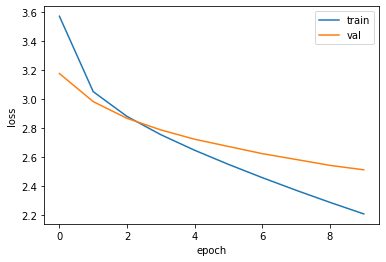

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

* 그래프로 확인 시 validation loss의 감소폭이 줄어드는 것을 볼 수 있다.

In [16]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [17]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you <end> '

### (2) embedding_size, hidden_size, batch_size 변동 O

### (2)-1. embedding_size = 256, hidden_size = 1536, batch_size=512, epoch = 10

In [18]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1536
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [19]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(512, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(512, 14, 12001), dtype=float32, numpy=
array([[[ 2.18499408e-04,  6.06722424e-05,  2.56924948e-04, ...,
         -1.62553610e-04,  4.32875549e-06, -2.55703344e-04],
        [ 4.36242117e-04, -2.65461567e-04,  5.97266131e-04, ...,
         -7.45826401e-05,  1.89352693e-04, -2.88448762e-04],
        [ 3.47174966e-04, -5.63009118e-04,  5.65462105e-04, ...,
         -5.97722610e-05,  2.18322763e-04, -2.97542079e-04],
        ...,
        [ 2.00871960e-03, -1.72287668e-03, -1.59552484e-03, ...,
         -8.94346158e-04,  7.70803483e-04,  9.03842098e-04],
        [ 2.09037377e-03, -1.62749575e-03, -1.67486281e-03, ...,
         -9.70432651e-04,  7.19982898e-04,  1.10251922e-03],
        [ 2.15095771e-03, -1.52275560e-03, -1.73408317e-03, ...,
         -1.03356573e-03,  6.73133938e-04,  1.27754395e-03]],

       [[ 2.18499408e-04,  6.06722424e-05,  2.56924948e-04, ...,
         -1.62553610e-04,  4.32875549e-06, -2.55703344e-04],
        [ 2.32918217e-04, -3.08867253e-04,  3

In [20]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  11016192  
_________________________________________________________________
lstm_3 (LSTM)                multiple                  18880512  
_________________________________________________________________
dense_1 (Dense)              multiple                  18445537  
Total params: 51,414,497
Trainable params: 51,414,497
Non-trainable params: 0
_________________________________________________________________


In [21]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=512, 
                     validation_data=(enc_val, dec_val), callbacks=[early_stopping_cb])    

Epoch 1/10
245/245 [==============================] - 153s 616ms/step - loss: 3.8238 - val_loss: 3.3754
Epoch 2/10
245/245 [==============================] - 151s 615ms/step - loss: 3.2621 - val_loss: 3.2126
Epoch 3/10
245/245 [==============================] - 151s 616ms/step - loss: 3.1203 - val_loss: 3.0792
Epoch 4/10
245/245 [==============================] - 151s 617ms/step - loss: 2.9858 - val_loss: 2.9770
Epoch 5/10
245/245 [==============================] - 151s 618ms/step - loss: 2.8784 - val_loss: 2.9002
Epoch 6/10
245/245 [==============================] - 151s 618ms/step - loss: 2.7848 - val_loss: 2.8324
Epoch 7/10
245/245 [==============================] - 151s 618ms/step - loss: 2.6984 - val_loss: 2.7800
Epoch 8/10
245/245 [==============================] - 151s 618ms/step - loss: 2.6194 - val_loss: 2.7298
Epoch 9/10
245/245 [==============================] - 151s 618ms/step - loss: 2.5464 - val_loss: 2.6916
Epoch 10/10
245/245 [==============================] - 151s 618m

* val_loss가 최저 2.6529까지만 내려간다.

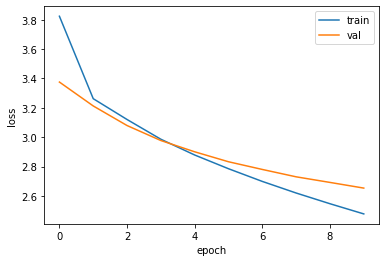

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

* 하이퍼파라미터에 변경을 줘서 학습시켜 보았다. 
* 이전과 비교 시 큰 차이점도 없었을 뿐더러 validation loss 감소폭에도 변화가 없다.

In [23]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [24]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m a motherfucking monster <end> '

### (2)-2. embedding_size = 128, hidden_size = 1536, batch_size=512, epoch = 10

In [25]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 128
hidden_size = 1536
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [26]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(512, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(512, 14, 12001), dtype=float32, numpy=
array([[[ 9.79155957e-05,  9.56032236e-05, -2.95756181e-04, ...,
         -4.62860407e-05, -6.32741067e-05,  8.53152233e-05],
        [-1.18024866e-04, -2.23680890e-05, -3.17116821e-04, ...,
         -1.07855369e-04, -2.59613007e-04,  1.20033892e-05],
        [-4.05446510e-04,  1.44826672e-05, -4.44897189e-04, ...,
         -2.49483535e-04, -3.19552259e-04, -4.75301313e-05],
        ...,
        [-1.00053707e-03,  5.95149759e-04,  3.44271743e-04, ...,
         -2.23142051e-04, -3.76104057e-04,  2.17275356e-05],
        [-1.11602177e-03,  5.85445552e-04,  7.47941202e-04, ...,
         -2.11931838e-04, -2.07534613e-04,  2.88133488e-05],
        [-1.23388937e-03,  5.65254421e-04,  1.12718344e-03, ...,
         -2.07348858e-04,  1.22967435e-06,  3.78055811e-05]],

       [[ 9.79155957e-05,  9.56032236e-05, -2.95756181e-04, ...,
         -4.62860407e-05, -6.32741067e-05,  8.53152233e-05],
        [ 3.32096715e-06,  2.34809977e-05, -3

In [27]:
model.summary()

Model: "text_generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  1536128   
_________________________________________________________________
lstm_4 (LSTM)                multiple                  10229760  
_________________________________________________________________
lstm_5 (LSTM)                multiple                  18880512  
_________________________________________________________________
dense_2 (Dense)              multiple                  18445537  
Total params: 49,091,937
Trainable params: 49,091,937
Non-trainable params: 0
_________________________________________________________________


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=512, 
                     validation_data=(enc_val, dec_val), callbacks=[early_stopping_cb])  

Epoch 1/10
245/245 [==============================] - 152s 612ms/step - loss: 3.6763 - val_loss: 3.2583
Epoch 2/10
245/245 [==============================] - 149s 610ms/step - loss: 3.1314 - val_loss: 3.0604
Epoch 3/10
245/245 [==============================] - 149s 610ms/step - loss: 2.9531 - val_loss: 2.9294
Epoch 4/10
245/245 [==============================] - 150s 611ms/step - loss: 2.8122 - val_loss: 2.8305
Epoch 5/10
245/245 [==============================] - 150s 611ms/step - loss: 2.6931 - val_loss: 2.7560
Epoch 6/10
245/245 [==============================] - 150s 611ms/step - loss: 2.5842 - val_loss: 2.6922
Epoch 7/10
245/245 [==============================] - 150s 611ms/step - loss: 2.4818 - val_loss: 2.6371
Epoch 8/10
245/245 [==============================] - 150s 611ms/step - loss: 2.3855 - val_loss: 2.5882
Epoch 9/10
245/245 [==============================] - 150s 611ms/step - loss: 2.2925 - val_loss: 2.5498
Epoch 10/10
245/245 [==============================] - 150s 611m

* val_loss가 최저 2.5117까지만 내려간다.

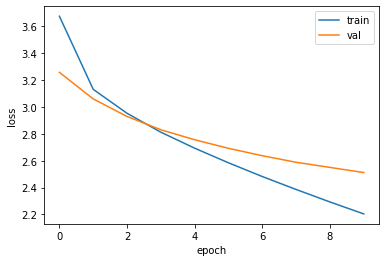

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

* 모델이 잡아내는 특성수가 많으면 과적합이 일어나거나, loss 감소폭이 줄어들 가능성이 있어  embedding_size를 줄여보았다.
* 바로 이전보다는 validation loss가 낮게 나오긴 했으나 여전히 좋지 않다.

In [30]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [31]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you <end> '

* 하이퍼파라미터로 로스값 2.2를 맞추는 것은 한계가 있어보인다.

### (3) Dropout 적용

### (3)-1. Dropout 1개 적용

* 하이퍼파라미터는 과적합의 가능성이 많아보였던 두 번째 값을 사용한다.
* embedding_size = 256, hidden_size = 1536, batch_size=512, epoch = 10

In [32]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)   
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(0.5)    # Dropout 적용
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.dropout(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1536
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [33]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(512, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(512, 14, 12001), dtype=float32, numpy=
array([[[ 1.4504729e-05, -2.7201601e-04, -1.5199246e-04, ...,
          1.4405079e-04, -3.7121036e-04, -1.1984059e-05],
        [ 1.1902028e-04, -1.5618560e-04, -2.2065795e-05, ...,
          2.6772017e-04, -7.2744570e-04, -1.7611648e-05],
        [ 3.0939296e-04, -4.3488137e-05,  6.4985499e-05, ...,
          5.1499764e-04, -8.9729356e-04, -2.4541598e-05],
        ...,
        [-2.6958817e-04,  1.9945348e-04, -7.8645302e-04, ...,
          5.5958959e-04,  4.5774420e-04, -5.9678347e-04],
        [-1.9584388e-04,  6.3310238e-04, -1.0591164e-03, ...,
          4.0184031e-04,  8.3387882e-04, -7.8323466e-04],
        [-1.3651750e-04,  1.0988673e-03, -1.3542227e-03, ...,
          2.4887308e-04,  1.2292044e-03, -9.2194369e-04]],

       [[ 1.4504729e-05, -2.7201601e-04, -1.5199246e-04, ...,
          1.4405079e-04, -3.7121036e-04, -1.1984059e-05],
        [ 2.7991036e-05, -4.1498934e-04, -4.1477659e-04, ...,
          2.5010799e-04, 

In [34]:
model.summary()

Model: "text_generator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_6 (LSTM)                multiple                  11016192  
_________________________________________________________________
lstm_7 (LSTM)                multiple                  18880512  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  18445537  
Total params: 51,414,497
Trainable params: 51,414,497
Non-trainable params: 0
_________________________________________________________________


In [35]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=512, 
                     validation_data=(enc_val, dec_val), callbacks=[early_stopping_cb])

Epoch 1/10
245/245 [==============================] - 153s 618ms/step - loss: 3.6444 - val_loss: 3.2387
Epoch 2/10
245/245 [==============================] - 151s 617ms/step - loss: 3.1338 - val_loss: 3.0448
Epoch 3/10
245/245 [==============================] - 151s 618ms/step - loss: 2.9624 - val_loss: 2.9105
Epoch 4/10
245/245 [==============================] - 151s 618ms/step - loss: 2.8334 - val_loss: 2.8087
Epoch 5/10
245/245 [==============================] - 151s 618ms/step - loss: 2.7253 - val_loss: 2.7328
Epoch 6/10
245/245 [==============================] - 151s 618ms/step - loss: 2.6283 - val_loss: 2.6655
Epoch 7/10
245/245 [==============================] - 151s 618ms/step - loss: 2.5364 - val_loss: 2.6098
Epoch 8/10
245/245 [==============================] - 151s 618ms/step - loss: 2.4494 - val_loss: 2.5595
Epoch 9/10
245/245 [==============================] - 151s 618ms/step - loss: 2.3676 - val_loss: 2.5119
Epoch 10/10
245/245 [==============================] - 151s 619m

* val_loss가 최저 2.5117까지만 내려간다.
* 앞에서 하이퍼파라미터만 조정해준 것보다는 낮은 수치를 보이고 있으나, 여전히 2.2 아래로 내려가진 않는다.

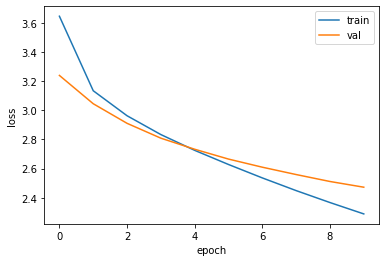

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

* Dropout(1개)을 설정했으나, Loss에는 크게 영향을 미치지 않는 것 같다.

In [37]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [38]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '

### (3)-2. Dropout 2개 적용

In [39]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.dropout2 = tf.keras.layers.Dropout(0.5)    # Dropout 적용
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.dropout1(out)
        out = self.rnn_2(out)
        out = self.dropout2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1536
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [40]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(512, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(512, 14, 12001), dtype=float32, numpy=
array([[[ 7.21428150e-05, -4.14107562e-05,  2.74716585e-05, ...,
          1.97455993e-05, -8.29822093e-05, -8.67220006e-05],
        [ 2.12371873e-04, -2.27781857e-05,  2.66238603e-05, ...,
         -1.54553592e-04,  2.16334302e-04, -1.32463931e-04],
        [ 7.40746545e-05,  2.40447596e-04,  2.86003683e-06, ...,
         -1.07446758e-04,  3.47758410e-04,  1.93671251e-04],
        ...,
        [ 3.17717018e-03,  1.18952198e-03, -1.12051540e-03, ...,
          7.38657895e-04,  1.25872227e-03, -2.82041612e-03],
        [ 3.43696820e-03,  1.33107207e-03, -1.30701694e-03, ...,
          7.93619896e-04,  1.26074860e-03, -3.17626516e-03],
        [ 3.66222789e-03,  1.46054826e-03, -1.48485601e-03, ...,
          8.25462863e-04,  1.24493672e-03, -3.49122309e-03]],

       [[ 7.21428150e-05, -4.14107562e-05,  2.74716585e-05, ...,
          1.97455993e-05, -8.29822093e-05, -8.67220006e-05],
        [ 2.24873103e-04, -7.79477489e-07,  1

In [41]:
model.summary()

Model: "text_generator_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_8 (LSTM)                multiple                  11016192  
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_9 (LSTM)                multiple                  18880512  
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  18445537  
Total params: 51,414,497
Trainable params: 51,414,497
Non-trainable params: 0
______________________________________

In [42]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=512, 
                     validation_data=(enc_val, dec_val), callbacks=[early_stopping_cb])

Epoch 1/10
245/245 [==============================] - 154s 618ms/step - loss: 3.7477 - val_loss: 3.3052
Epoch 2/10
245/245 [==============================] - 151s 617ms/step - loss: 3.1952 - val_loss: 3.1040
Epoch 3/10
245/245 [==============================] - 151s 617ms/step - loss: 3.0358 - val_loss: 2.9720
Epoch 4/10
245/245 [==============================] - 151s 618ms/step - loss: 2.9087 - val_loss: 2.8705
Epoch 5/10
245/245 [==============================] - 151s 619ms/step - loss: 2.8089 - val_loss: 2.7966
Epoch 6/10
245/245 [==============================] - 151s 618ms/step - loss: 2.7241 - val_loss: 2.7352
Epoch 7/10
245/245 [==============================] - 151s 618ms/step - loss: 2.6464 - val_loss: 2.6789
Epoch 8/10
245/245 [==============================] - 151s 618ms/step - loss: 2.5746 - val_loss: 2.6350
Epoch 9/10
245/245 [==============================] - 151s 619ms/step - loss: 2.5076 - val_loss: 2.5897
Epoch 10/10
245/245 [==============================] - 151s 618m

* val_loss가 최저 2.5546까지만 내려간다.
* 앞에서 Dropout을 한 번 준 것과 비교했을 때 유의미한 차이를 보이지 않으며, loss가 여전히 2.2 아래로 내려가지 않는다.

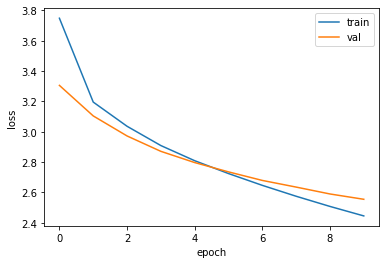

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

* Dropout(2개)을 설정했으나, Loss에는 크게 영향을 미치지 않는 것 같다.

* 하이퍼파라미터 조정, Dropout의 사용으로 10epoch안에 loss값을 2.2로 만드는 시도들을 해보았다.
* 사실 그래프로만 봤을 때 모든 결과에서 val_loss가 꾸준히 감소하고 있기 때문에 과적합이 일어났다고 볼 수 없다고 생각한다.
* 그래서 과대적합을 저지하기 위한 방법들이 loss 감소 변화에 큰 영향을 미치지 않은 것 같다.
* epoch를 더 늘리면 Loss가 2.2가 되는 시점을 확인 할 수 있을 것 같으나, 과적합이 일어날 가능성이 있다. 
* 하이퍼파라미터 조정, Dropout의 사용으로는 Loss가 개선되지 않는 것을 확인할 수 있다.
* 과대적합을 방지하기 위한 여러 방법들이 많이 있는데, 위 결과로 봐서는 비슷한 결과가 나오지 않을까 싶다.

In [44]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [45]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna be <end> '

### (5) train세트에서 다시 train, validation 세트로 나누기

* 일반적으로 `train_test_split()` 함수를 사용해서 validation 세트를 만들어야 하는 경우, 함수를 2번 사용해서 validation 세트를 만든다. (경량화)

In [46]:
enc_val_train, enc_val_val, dec_val_train, dec_val_val = \
train_test_split(enc_train, dec_train, test_size = 0.125 , random_state = 15)

In [47]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124981, 14)
Target Train: (124981, 14)


In [48]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256   # 단어가 추상적으로 표현되는 크기(고려하는 feature의 수)
hidden_size = 1024     # 모델에 둘 일꾼의 수(많으면 배가 산으로)
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [49]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(256, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-3.46070359e-04,  3.81187943e-04, -1.25394901e-04, ...,
          2.21728915e-04,  7.34533678e-05, -1.48049265e-04],
        [-5.28283068e-04,  6.73872826e-04, -7.93862491e-05, ...,
          5.92489778e-05,  4.67368372e-05, -4.45327314e-05],
        [-5.78446838e-04,  8.42378708e-04, -1.42695775e-04, ...,
          2.54438164e-05, -5.68664109e-05,  5.52932688e-05],
        ...,
        [ 7.08911335e-04,  1.36492029e-03,  2.84177077e-04, ...,
         -8.33206504e-05,  3.82674672e-03, -8.77404644e-04],
        [ 1.12453685e-03,  1.63545157e-03, -9.26837820e-05, ...,
         -1.09930581e-04,  4.55039460e-03, -1.03632640e-03],
        [ 1.51643937e-03,  1.88006659e-03, -4.76511428e-04, ...,
         -1.07826629e-04,  5.21020265e-03, -1.16135995e-03]],

       [[-3.46070359e-04,  3.81187943e-04, -1.25394901e-04, ...,
          2.21728915e-04,  7.34533678e-05, -1.48049265e-04],
        [-8.24987481e-04,  4.67586564e-04, -2

In [50]:
model.summary()

Model: "text_generator_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_10 (LSTM)               multiple                  5246976   
_________________________________________________________________
lstm_11 (LSTM)               multiple                  8392704   
_________________________________________________________________
dense_5 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [51]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=256, validation_data = (enc_val_val, dec_val_val)) 

Epoch 1/10
489/489 [==============================] - 86s 171ms/step - loss: 3.4862 - val_loss: 3.1053
Epoch 2/10
489/489 [==============================] - 83s 170ms/step - loss: 3.0185 - val_loss: 2.8949
Epoch 3/10
489/489 [==============================] - 83s 170ms/step - loss: 2.8580 - val_loss: 2.7557
Epoch 4/10
489/489 [==============================] - 83s 170ms/step - loss: 2.7351 - val_loss: 2.6407
Epoch 5/10
489/489 [==============================] - 83s 170ms/step - loss: 2.6284 - val_loss: 2.5360
Epoch 6/10
489/489 [==============================] - 83s 170ms/step - loss: 2.5333 - val_loss: 2.4459
Epoch 7/10
489/489 [==============================] - 83s 171ms/step - loss: 2.4453 - val_loss: 2.3572
Epoch 8/10
489/489 [==============================] - 83s 170ms/step - loss: 2.3624 - val_loss: 2.2781
Epoch 9/10
489/489 [==============================] - 84s 171ms/step - loss: 2.2848 - val_loss: 2.1989
Epoch 10/10
489/489 [==============================] - 83s 171ms/step - l

* val_loss가 최저 2.1239까지 내려간다.

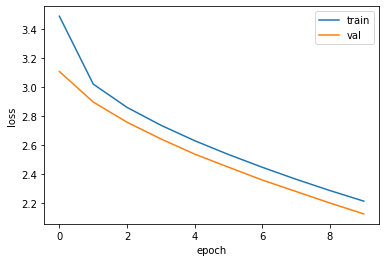

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

* 그래프로 확인 시 감소 추이가 train과 비슷하게 진행된다.

In [53]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [54]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , baby <end> '

### (5) 모델 자체의 성능 개선

* 논문 'A Performance Analysis by Adjusting Learning Methods in Stock Price Prediction Model Using LSTM'에서는 LSTM모델의 성능 조합을 여러 가지로 바꿔보면서 성능이 가장 잘 나오는 조합에 대해 연구했다.
* 주가를 예측하는 도구로 LSTM의 모델을 사용한 것이다.
* Exploration과 관련이 없는 방식으로 모델을 사용했으나, 모델 성능 개선 방식을 Exploration에 적용해보고자 한다.

* 초기화(Initialization) 방법
  * kernel initializer = Xavier normal(glorot normal)
  * recurrent initializer = random normal
  * bias initializer = he uniform

* 정규화(Regularization) 방법
  * kernel = L2 적용
  * recurrent = L1, L2 모두 유의미한 변화를 보이지 않음
  * bias = L1, L2 모두 유의미하게 성능이 나빠짐
  * activity = L1 적용 시 유의미하게 성능이 매우 나빠짐, L2 적용 시 유의미하게 성능이 좋아짐
  * 따라서, activity는 L2(0.1), kernel이 L2(0.003)일 때 약간 성능이 좋아짐
* 활성화(Activation)함수
  * 기본 활성화 함수와 순환 활성화 함수의 조합으로 기본 설정인(tanh, hard sigmoid)가 가장 성능이 좋음
* 최적화(Optimization) 함수
  * 활성화 함수가 tanh일 때 최적화 함수 Adam일 경우가 가장 성능이 좋음

In [55]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                          activity_regularizer=tf.keras.regularizers.l2(0.1), return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                          activity_regularizer=tf.keras.regularizers.l2(0.1), return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1536
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

* 논문에서 언급하고 있는 내용을 모두 적용해보고 싶었으나, 능력 부족으로 전부 다 적용해보진 못 했다.
* 모델 초기화 부분과 관련해서 자꾸 에러가 발생하고 있다.
* 모델 초기화에 대해 공부를 더 하고난 후 적용해봐야 할 것 같다.

In [56]:
# corpus 텐서를 tf.data.Dataset객체로 변환
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(len(src_input))
dataset = dataset.batch(512, drop_remainder=True)

# model에 작은 데이터셋으로 input shape를 결정
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(512, 14, 12001), dtype=float32, numpy=
array([[[ 3.1422186e-04, -1.6420848e-04, -1.1393029e-04, ...,
         -5.2127580e-05,  1.7800914e-04, -5.5337856e-05],
        [ 5.3889485e-04, -1.1814782e-04, -3.4493900e-05, ...,
          1.4374564e-04, -9.0674825e-05, -1.8311784e-04],
        [ 7.9618767e-04, -2.0750742e-04, -2.8063272e-04, ...,
          5.2657019e-04, -1.2693889e-04, -8.9753448e-05],
        ...,
        [ 4.9336883e-04, -1.2798933e-03,  9.7433757e-04, ...,
          3.9693082e-04,  1.0177771e-03,  8.7753913e-05],
        [ 2.8556635e-04, -1.2930931e-03,  1.3245449e-03, ...,
          4.3731931e-04,  7.3923176e-04,  9.8766934e-05],
        [ 1.5547972e-04, -1.3323956e-03,  1.5765491e-03, ...,
          5.0720578e-04,  4.1635692e-04,  2.8637788e-04]],

       [[ 3.1422186e-04, -1.6420848e-04, -1.1393029e-04, ...,
         -5.2127580e-05,  1.7800914e-04, -5.5337856e-05],
        [ 5.3159939e-04, -2.5208120e-04,  1.0123911e-04, ...,
         -1.7517681e-04, 

In [57]:
model.summary()

Model: "text_generator_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_12 (LSTM)               multiple                  11016192  
_________________________________________________________________
lstm_13 (LSTM)               multiple                  18880512  
_________________________________________________________________
dense_6 (Dense)              multiple                  18445537  
Total params: 51,414,497
Trainable params: 51,414,497
Non-trainable params: 0
_________________________________________________________________


In [58]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(enc_train, dec_train, epochs=10, batch_size=512, 
                     validation_data=(enc_val, dec_val), callbacks=[early_stopping_cb])

Epoch 1/10


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:238 __call__
        total_loss_metric_value = tf.add_n(loss_metric_values)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:4000 add_n
        return gen_math_ops.add_n(inputs, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:401 add_n
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Shapes must be equal rank, but are 2 and 0
    	From merging shape 0 with other shapes. for '{{node AddN_1}} = AddN[N=2, T=DT_FLOAT](sparse_categorical_crossentropy/weighted_loss/Mul, AddN)' with input shapes: [?,14], [].


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 3. 결과

* embedding_size, hidden_size, batch_size 변동 X 
  * val_loss : 2.5116
  * 출력된 문장 : i love you , i love you 
* embedding_size = 256, hidden_size = 1536, batch_size=512, epoch = 10
  * val_loss : 2.6529
  * 출력된 문장 : i love you , i m a motherfucking monster 
* embedding_size = 128, hidden_size = 1536, batch_size=512, epoch = 10
  * val_loss : 2.5117
  * 출력된 문장 : i love you , i love you 
* Dropout 1개 적용
  * val_loss : 2.4727
  * 출력된 문장 : i love you , i m not gonna crack
* Dropout 2개 적용
  * val_loss : 2.5546
  * 출력된 문장 : i love you , i m not gonna be
* train세트에서 다시 train, validation 세트로 나누기
  * val_loss : 2.1239
  * 출력된 문장 : i love you , baby

* 마지막 결과가 제일 자연스럽게 나온것 같아 보인다.
* 모델의 훈련이 제대로 이루어지지 않으면 만족스러운 결과가 나오지 않는 것을 확인할 수 있었다.

## 4. 회고

### (1) 이번 프로젝트에서 어려웠던 점

* 루브릭 지표 10 epoch이내에 loss가 2.2 맞추는 것이 제일 힘들었다.
* 다양한 방법을 더 시도해보고 싶었지만 학습되는 시간이 너무 오래걸려서 시도해보지 못한게 너무 아쉽다.

### (2) 프로젝트 진행하면서 알게된 내용

* 순환 신경망(Recurrent Neural Network, RNN) : 히든 노드가 방향을 가진 엣지로 연결돼 순환구조를 이루는(directed cycle) 인공신경망의 한 종류. Convolutional Neural Networks(CNN)과 더불어 최근 들어 각광 받고 있는 알고리즘
* LSTM : RNN은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 그래디언트가 점차 줄어 학습능력이 크게 저하되는 것으로 알려져 있다. 이를 vanishing gradient problem이라고 하며, 이 문제를 극복하기 위해서 고안된 것이 바로 LSTM이다. 
* 모델의 과적합을 막기위한 다양한 방법 : Dropout, 라쏘, 릿지, 모델의 단순화, 최적화
* history = model.fit() : fit() 메서드의 결과를 hitory에 담는 경우 훈련 측정값(에포크마다 계산된 손실)이 담긴 history 딕셔너리가 생성된다..
* Callback : 훈련과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들이다. 
* EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다.
* ordereddict함수 : set함수를 사용하면 중복되는 요소를 삭제해주면서 순서가 뒤바뀌게 된다. 순서를 유지하면서 요소를 삭제하고 싶은 경우에 사용하는 함수

### (3) 루브릭 평가 지표를 맞추기 위해 시도한 것들

* 하이퍼파라미터 수정
  * embedding_size : 8 ~ 512, hidden_size : 1024 ~ 2048, batch size : 50 ~ 512까지의 숫자들 중 다양한 조합으로 시도해보았다. 
  * 위 내용은 하이퍼파라미터를 다양하게 해본 결과들 중 그나마 나은 것들을 기재한 것이다.
  * 하이퍼파라미터만 수정해서는 루브릭을 맞추기에는 한계가 있어 보인다. 
* Dropout 적용
  * Dropout을 1,2개까지 적용시켜 시도해보았다. loss 감소에는 큰 영향이 없었다.
* `train_test_split()` 함수 사용
  * `train_test_split()` 함수를 사용해 train 세트를 다시 train과 val 세트로 나눠 훈련을 진행했다.
* 모델 자체의 성능 개선 
  * 에러가 발생해 확인하고 싶었던 내용을 전부 확인해보지 못했다.
* 데이터 정리
  * 이번 프로젝트 진행에 사용된 데이터들 중 대소문자만 다르고 파일명이 같은 파일이 6개 발견했다.
  * 데이터 자체에 반복되는 문장들이 너무 많아 중복 문장을 삭제 후 모델 훈련을 진행해보았다.
  * 중복 문장 삭제 시 데이터가 약 12만개에서 8만개로 줄었다.
  * 데이터가 너무 작아지는 현상이 발생해 모델 훈련에 적합하지 않다 생각했다.
  * 그럼에도 해당 데이터를 사용해 훈련을 진행했을 시 눈에 띄는 loss 감소를 확인할 수는 없었다.

### (4) 루브릭 평가 지표를 달성하지 못한 이유

* 여러 가지 시도는 해보았지만, 모델이 10 epoch 내에 loss가 2.2까지 도달하지 못하는 원인에 대한 파악이 제대로 이루어지지 않았다.
* 문제의 원인이 제대로 파악되지 못한 채 진행하다보니, 제대로 해결책을 찾지 못한 것 같다. 

### (5) 더 시도해보면 좋았을 것들, 자기 다짐

* 더 시도해보면 좋았을 것들
 * 에포크를 10보다 조금 더 늘려보면 2.2가 나오지 않을까 싶다. callback함수를 써서 epoch를 최대한 늘리고
   과대적합이 되는 시점에서 훈련이 중단되게 만들면 2.2가 나오는 순간을 확인할 수 있지 않을까?
 * LSTM layer를 더 추가해봤을 때의 결과도 궁금하다.
   (모델이 늘어나면 모수가 증가해 loss가 증가한다는 글을 보긴 했으나, 실제 결과가 어떻게 나올지 궁금하다.)

* 자기다짐
  * 자연어처리는 나랑 안 맞는 것 같다. Exploration이 너무 힘들어서 그런가.
  * 이번 Exploration은 다른 것들보다 팀원들하고 활발하게 의견을 나눠가면서 진행해서 그런가 좀 더 기억에 잘 남는듯한 느낌이 든다.
  * 다른 Exploration할 때로 활발한 의견 교류가 필요할 것 같다.

### 5. 참고 자료

* Overfitting(과적합) 해결 \
https://velog.io/@yookyungkho/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%98-%EA%B3%A0%EC%A7%88%EB%B3%91-Overfitting%EA%B3%BC%EC%A0%81%ED%95%A9-%ED%95%B4%EA%B2%B0-%ED%8C%81 

* RNN과 LSTM을 이해해보자! \
https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/

* LSTM layer \
https://keras.io/api/layers/recurrent_layers/lstm/

* file data 중복 제거 구현 \
https://velog.io/@cosmos/Python%EC%97%90%EC%84%9C-file-%EB%82%B4%EC%9A%A9-%EC%A4%91-%EC%A4%91%EB%B3%B5%EB%90%98%EB%8A%94-%EB%82%B4%EC%9A%A9-%EC%A0%9C%EA%B1%B0%ED%95%98%EA%B8%B0

* ordereddict함수 \
https://hengbokhan.tistory.com/82

* A Performance Analysis by Adjusting Learning Methods in Stock Price Prediction Model Using LSTM \
https://www.koreascience.or.kr/article/JAKO202034352379471.pdf